In [1]:
#Uploading required packages
import numpy as np
from scipy.stats import gamma
from scipy.stats import uniform as unif
from scipy.stats import multivariate_normal as mvtnorm
from scipy.stats import bernoulli
from numba import jit
import matplotlib.pyplot as plt
%matplotlib inline

# <center> STA 663 Final Project <center>
## <center>  The Indian Buffet Process and Applications for Unsupervised Learning <center> 
### <center> Sunith R. Suresh & Drew Jordan <center> 

### 1. Introduction

In un-supervised learning, the goal is to determine latent (hidden) features from unlabeled data groups. In other words, we would like to group the data into categories, such that the categories are learned from the data itself. One way is to use a standard clustering algorithm like k-means or Gaussian mixture modeling. The problem is that both these methods assume a fixed number of groups that are determined by the user. Unfortunately, most real world data do not have a fixed number of groups. Non-parametric Bayesian methods allow us to model such data by allowing the number of groups to grow with the addition of more data. One such non-parametric method is the Chinese Restaurant Process, where we allocate a data point to a group with some probability while also allowing a data point to form a new group. The Indian Buffet Process is an extension of the Chinese Restaurant Process in which we allow data points to belong to multiple groups. For the purpose of this paper, we shall implement the algorithm described in the paper “Infinite Latent Feature Models and the Indian Buffet Process” by Griffiths and Ghahramani (2005). We will simulate an image dataset similar to that used in Griffiths and Ghahramani (2005) to test our code. Once we implement the algorithm, we shall attempt to optimize it for computational efficiency. 

### 2. The Indian Buffet Process

The Indian buffet process (IBP) is a stochastic process for defining the probability distribution over equivalence classes of sparse binary matrices with a finite number of rows and an unbounded number of columns. 

The IBP is best described with the help of a culinary metaphor. Customers (observations) sequentially arrive at an Indian buffet with a infinite number of dishes (features). The first customer samples $Possion(\alpha)$ dishes. The $i^{th}$ customer arrives and samples the already sampled dishes with a probability proportional to the popularity of that dish prior to his arrival (i.e, proportional to $\frac{n_{-i,k}}{i}$, where $n_{i,k}$ is the number of customer who sampled dish $k$ prior to the arrival of the $i^{th}$ customer). After the customer samples the already sampled dishes, he proceeds to further sample another $Poisson(\frac{\alpha}{i})$ number of new dishes. This process continues till all $N$ customers have visited the buffet (Yildrim, 2012).

The outcome of the Indian Buffet Process can be represented by a binary matrix $Z$ where the rows (denoted by $i$) are customers(observations) and the columns(denoted by k) are dishes(features). If the value in a particular row and columns is 1, it denotes that observation $i$ possesses feature $k$. 

For better intuition over the $\alpha$ parameter, below are three matrices generated from IBP for varying values of $\alpha ={2, 4, 6}$ with number of observation set to 10. 

In [2]:
# Indian Buffet Process Function

def sampleIBP(alpha, num_objects):  
    # Initializing storage for results
    result = np.zeros([num_objects, 1000])
    # Draw from the prior for alpha
    t = np.random.poisson(alpha)
    # Filling in first row of result matrix
    result[0, 0:t] = np.ones(t) #changed form np.ones([1, t])
    # Initializing K+
    K_plus = t
    
    for i in range(1, num_objects):
        for j in range(0, K_plus):
            p = np.array([np.log(np.sum(result[0:i,j])) - np.log(i+1), 
                          np.log(i+1 - np.sum(result[0:i, j])) - np.log(i+1)])
            p = np.exp(p - max(p))

            if(np.random.uniform() < p[0]/np.sum(p)):
                result[i, j] = 1
            else:
                result[i, j] = 0
        t = np.random.poisson(alpha/(i+1))
        x = K_plus + 1
        y = K_plus + t
        result[i, (x-1):y] = np.ones(t) #changed form np.ones([1, t])
        K_plus = K_plus+t
    result = result[:, 0:K_plus]
    
    return list([result, K_plus])

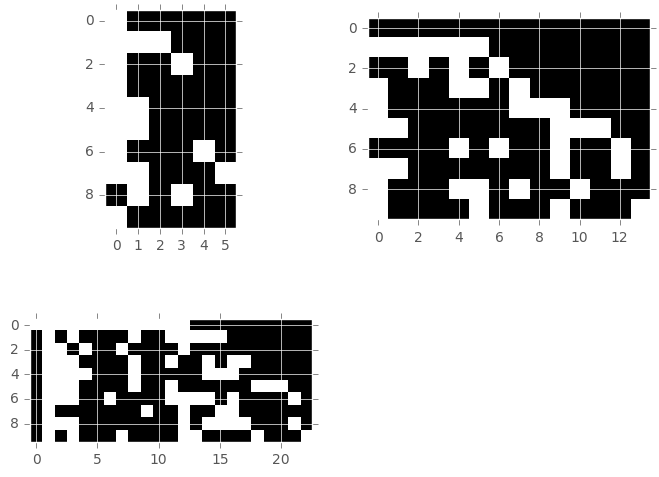

In [26]:
np.random.seed(1234)
[Z_alpha2,K1] = sampleIBP(2, 10)
[Z_alpha3,K3] = sampleIBP(4, 10)
[Z_alpha5,K5] = sampleIBP(6, 10)


fig = plt.figure()
a=fig.add_subplot(2,2,1)
plt.imshow(Z_alpha2,cmap=plt.get_cmap('gray'),  interpolation='nearest')
a=fig.add_subplot(2,2,2)
plt.imshow(Z_alpha3,cmap=plt.get_cmap('gray'),  interpolation='nearest')
a=fig.add_subplot(2,2,3)
plt.imshow(Z_alpha5,cmap=plt.get_cmap('gray'),  interpolation='nearest')
plt.show()

Above we have three images for the binary matrix Z generated from the Indian Buffet Process for $\alpha ={2, 4, 6}$. In the above images, a white pixel represents a value of 1 while a black pixel represents a value of 0. $\alpha$ can be viewed as a concentration parameter. For equal number of observations, $\alpha$ influences how likely it is that multiple observations share the same feature.

Two aspects of the Indian Buffet make it suitable for latent feature modeling (Yildrim, 2012)

1. It defines a probability distribution over rich combinatoric structures (We can interpret binary matrices are feature ownership tables, adjacency matrices, etc.)

2. A priori, IBP has support over binary matrices with any number of columns. Upon observing data, IBP concentrates its mass over a subset of binary matrices with finitely many columns via probabilistic inferences. Therefore IBP, allows binary matrices to grow and shrink with more data.

The IBP assumes that latent features are binary, so an observation either does or does not possess a feature. Also it assumes that latent features are statistically independent, so knowledge that an observation possess a certain feature does not provide information about whether it possesses other features (Yildrim, 2012)

Formally, the probability of a binary matrix, $Z \sim IBP(\alpha)$ is given by


$$P(Z| \alpha) = \frac{\alpha^{K}}{\prod_{h=1}^{2^N - 1} K_{h}!} exp \{ - \alpha H_{N}\} \prod_{k=1}^{K} \frac{(N- m_k)! (m_k - 1)!}{N!}$$

$N$ - Number of objects

$K$ - Number of features

$K_h$ - Number of features with history h 

$H_N$ - $N^{th}$ Harmonic number

$m_k$ - Number of objects with feature k

$\alpha$ - parameter influencing the Indian Buffet Process

A detailed derivation of the equation can be found in Griffiths & Ghahramani, 2005.


The conditional distribution can be given by

$$ P( z_{i,k} = 1 \mid z_{-i,k}) = \frac{n_{-i, k}}{N}$$

### 3. Application of the Indian Buffet Process for Unsupervised Latent Feature Learning

### 3.1 Linear Gaussian Model

We shall demonstrate the application of the IBP, by using it as a prior for unsupervised latent feature learning. We shall consider a simple linear-Gaussian model described by Griffiths & Ghahramani (Griffiths & Ghahramani, 2005).

Let $Z$ be a binary feature ownership matrix, where $z_{i,k}=1$ indicating that object $i$ posssess feature $k$

Let's assume $Z \sim IBP(\alpha)$

Let X be real-valued observation, where $x_{i,j}$ is the value of feature $j$ for object $i$. $X$ is a ${N x D}$ matrix.

Let $z_i$ be feature values for object $i$ and let $x_i$ be the observed values for object $i$.  Using a linear gaussian model

$$x_i \sim N(z_i W, \sigma_x^2 I) $$

where $W$ is a $\textit{K x D}$ matrix of weights representing the $\textit{K}$ latent features,

$$W \sim N(0, \sigma_w^2 I)$$

The likelihood is given by

$$p( X \mid Z, W, \sigma_x^2) = \frac{1}{(2 \pi \sigma_x^2)^{\frac{N D}{2}}} exp\{ -\frac{1}{2 \sigma_x^2} tr((X-ZW)^{T} (X-ZW)^{T}))\} $$


Marginalizing out $W$

$$P(X|Z,\sigma_X, \sigma_A) = \frac{1}{(2 \pi)^{ND/2} (\sigma_X)^{(N-K)D}(\sigma_A)^{KD}(|Z^TZ+\frac{\sigma_X^2}{\sigma_A^2}I|)^{D/2}} exp\{-\frac{1}{2\sigma_X^2}tr(X^T(I-Z M Z^T)X)\}$$

where $$ M = (Z^TZ+\frac{\sigma_X^2}{\sigma_A^2}I)^{-1}$$

### 3.2 Inference with MCMC Sampling Methods  

Exact inferences is intractable and instead, we can get approximate inferences using Markov Chain Monte Carlo (MCMC) sampling methods. The MCMC method we use is proposed by Griffiths and Ghahramani (Griffiths and Ghahramani, 2005)

#### Parameters of Interest

We have five parameters of interest in our model that we need to update throughout our MCMC process.

1.) Z: feature ownernship matrix

2.) $K_+$: number of new latent features

3.) $\alpha$ parameter controlling  $K_+$

4.) $\sigma_x$

5.) $\sigma_A$

There are full conditional distributions for Z, $K_+$, and $\alpha$, so we will update them using Gibbs Sampling. We will update $\sigma_X$ and $\sigma_A$ using random-walk Metropolis-Hastings.

#### Prior Distributions

The priors we used are

$$P(z_{ik} = 1 | \textbf{z}_{-i,k}) = \dfrac{n_{-i,k}}{N} $$

$$\alpha \sim Gamma(1,1)$$

$$K_+ \sim Poisson(\dfrac{\alpha}{N})$$


#### Gibbs Sampling Updates

1. For observation $i$ with more than one feature, sample $z_{i,k}$ using the full conditional distribution.

$$P(z_{ik}|X,Z_{-(i,k),},\sigma_X,\sigma_A) \propto  P(X|Z,\sigma_X, \sigma_A) * P(z_{ik}=1|\textbf{z}_{-i,k})$$

2. Sample new features for observation $i$ by first computing a truncated distribution for $K_+$ using the data likelihood and the  prior for $K_+$ up to 4 new features, and then sampling from the truncated distribution. 

3. Sample $P(\alpha \mid Z) \sim Gamma(1 + K_+, 1 + \sum_{i=1}^{N} H_i)$

#### Metropolis-Hasting Updates

Update $\sigma_X$ and $\sigma_A$ using Metropolis-Hastings. For $\sigma_X$, generate a random value from a Uniform(-.05, .05) distribution and add this value to our current value of $\sigma_X$ to get $\sigma_X^*$. Accept new value of $\sigma_X$ with probability:

$$p = min(1, \dfrac{P(X|Z, \sigma_X^*, \sigma_A}{P(X|Z, \sigma_X, \sigma_A})$$

To update $\sigma_A$, follow the same proceedure as with $\sigma_X$, replacing $\sigma_X$ with $\sigma_A$.

### 4. A Demonstration with Simulated Data

#### 4.1 Latent Features 

For a demonstration of the algorithim, we simulated image data as proposed by Yildrim (Yildrim, 2012). Four base images were created consisting of ${6 x 6}$ pixels. Each base image can be represented by a vector of length $36 \big( 6* 6 \big)$. These base images represent the latent features, which can be represented by a $K x D$ weight matrix $W$ where $K=4$ and $D=36$.

The four base (latent) images are shown below:


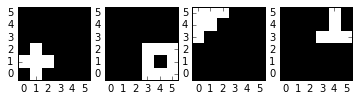

In [4]:
#Data Simulation

#Latent Features
W = np.array([[0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
              [0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
              [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0],
              [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0]])

##Latent Features
fig = plt.figure()
a=fig.add_subplot(1,4,1)
plt.imshow(np.matrix(W[0]).reshape(6,6),cmap=plt.get_cmap('gray'),  interpolation='nearest',origin='lower')
a=fig.add_subplot(1,4,2)
plt.imshow(np.matrix(W[1]).reshape(6,6),cmap=plt.get_cmap('gray'),  interpolation='nearest',origin='lower')
a=fig.add_subplot(1,4,3)
plt.imshow(np.matrix(W[2]).reshape(6,6),cmap=plt.get_cmap('gray'),  interpolation='nearest',origin='lower')
a=fig.add_subplot(1,4,4)
plt.imshow(np.matrix(W[3]).reshape(6,6),cmap=plt.get_cmap('gray'),  interpolation='nearest',origin='lower')
plt.show()

#### 4.2 Simulated Images

We then created 100 synthetic images, where each image $x_i$ is a superposition of zero or more base images (latent features) with added white noise. $X$ is a $100 x D$ matrix

$$x_i \sim N(z_i W, \sigma_x^2 I) $$

Here, $z_i$ represents a row of a binary feature matrix $Z$ of dimension $100 x K$. A values in $z_i$ is 1 or 0 with a probability of 0.5. A value of 1 in $z_i$ corresponds to image $x_i$ containing the correspoing base image. $\sigma_x^2$, which controls the white noise, is set to 0.5.

Below is an example of one such simulated image:

In [5]:
#set seed
np.random.seed(1234)

#Each image in our simulated data set is the superposition of four base images#
# Number of images/ data points
num_objects=100

#Dimension of image (6x6)
object_dim  = 6*6

#Covariance matrix for images/ white noise
sigma_x_orig = 0.5
I = sigma_x_orig * np.identity(object_dim)

#z_i - binary feature matrix (1 x 4) - each entry set to 1 with probability 0.5 and 0 otherwise#
#x is data variable - each row correspondes to a superimposed built from a random combination of latent features#
#with white noise added - x is built with multivariate gaussian#
image_data = np.zeros((100,36))
z_org = np.zeros((100,4))

for i in range(0,num_objects):
    z_org[i,:] = np.array([bernoulli.rvs(p=0.5, size=4)])
    image_data[i,:] = np.dot(z_org[i,:],W) + np.random.normal(0,1, (1,object_dim)).dot(I) 

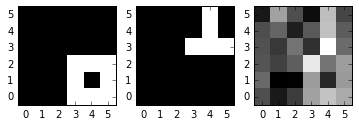

In [6]:
#Simulated Data
fig = plt.figure()
a=fig.add_subplot(1,3,1)
plt.imshow(np.dot(z_org[1,1],W)[1,:].reshape(6,6),cmap=plt.get_cmap('gray'),  interpolation='nearest',origin='lower')
a=fig.add_subplot(1,3,2)
plt.imshow(np.dot(z_org[1,3],W)[3,:].reshape(6,6),cmap=plt.get_cmap('gray'),  interpolation='nearest',origin='lower')
a=fig.add_subplot(1,3,3)
plt.imshow(np.matrix(image_data[1,:]).reshape(6,6),cmap=plt.get_cmap('gray'),  interpolation='nearest',origin='lower')
pass

$x_1$ in our simulated data set is a superimposition of base images(latent features) 2 & 4, with added white noise

### 5. Profiling & Optimization


### 5.1 Original MCMC sampler

The code for our MCMC sampler is as follows:


In [7]:
'''Helper Functions'''

# This function return the log likelihood
def likelihood(X, Z, M, sigma_A, sigma_X, K_plus, num_objects, object_dim):
    part1 = (-1)*num_objects*(0.5*object_dim)*np.log(2*np.pi)
    part2 = (-1)*(num_objects-K_plus)* object_dim *np.log(sigma_X) 
    part3 = (-1)*object_dim*K_plus*np.log(sigma_A) 
    part4 = (-1)*(0.5*object_dim)* np.log(np.linalg.det((np.dot(Z.T, Z) + (sigma_X**2/sigma_A**2)*np.eye(K_plus)))) 
    part5 = (-1/(2*sigma_X**2)) * np.trace(np.dot(np.dot(X.T,(np.identity(num_objects) - np.dot(np.dot(Z,M),Z.T))),X))
    total = part1+part2+part3+part4+part5
    return(total)

#This function computes matrix M
def Mcalc(Z, sigma_X, sigma_A, K_plus):
    M = np.linalg.inv(np.dot(Z.T, Z) + (sigma_X**2/sigma_A**2) * np.eye(K_plus))
    return(M)

#This function samples new value of Z[i,k] using Gibbs Sampling
def Met_zval(data, Z, sigma_X, sigma_A, K_plus, num_objects, object_dim, i, k):    
    
    P=np.zeros(2)

    Z[i,k]=1
    #Compute posterior density of new_sample
    M = Mcalc(Z, sigma_X, sigma_A, K_plus)
    P[0] = likelihood(data, Z, M, sigma_A, sigma_X, K_plus, num_objects, object_dim) + np.log(np.sum(Z[:, k]) - Z[i,k]) - np.log(num_objects)

    #Set new_sample to 0
    Z[i,k]=0
    #Computer posterior density of new_sample
    M = Mcalc(Z, sigma_X, sigma_A, K_plus)
    P[1] = likelihood(data, Z, M, sigma_A, sigma_X, K_plus, num_objects, object_dim) + np.log(num_objects - np.sum(Z[:,k])) - np.log(num_objects)

    P = np.exp(P - np.max(P))

    if np.random.uniform(0,1) < (P[0]/(np.sum(P))):
        new_sample = 1
    else:
        new_sample = 0
    
    return(new_sample)


#This function samples new dishes upto a range specified by trunc_val
def New_dishes(data, Z, sigma_X, sigma_A, K_plus, alpha, num_objects, object_dim, trunc_val,i):
    trunc = np.zeros(trunc_val)
    alpha_N = alpha/num_objects

    for k_i in range(0,trunc_val):
        Z_temp = Z
        if k_i>0:
            newcol = np.zeros((num_objects, k_i))
            newcol[i,:] = 1 
            Z_temp = np.column_stack((Z_temp, newcol))
        M = Mcalc(Z_temp, sigma_X, sigma_A, K_plus+k_i)
        trunc[k_i] = k_i * np.log(alpha_N) - alpha_N - np.log(np.math.factorial(k_i)) + likelihood(data, Z_temp, M, sigma_A, sigma_X, K_plus+k_i, num_objects, object_dim)

    trunc = np.exp(trunc - np.max(trunc))
    trunc = trunc/np.sum(trunc)

    p = np.random.uniform(0,1)
    t = 0
    new_dishes = 0

    for k_i in range(0,trunc_val):
        t = t + trunc[k_i]
        if p < t:
            new_dishes = k_i
            break
            
    return(new_dishes)

#The function updates both sigma_X and sigma_A using random-walk Metropolis-Hastings.
def Met_sigma(data, Z, sigma_X, sigma_A, K_plus, num_objects, object_dim):
    
    M = Mcalc(Z, sigma_X, sigma_A, K_plus)  
    lik_curr = likelihood(data, Z, M, sigma_A, sigma_X, K_plus, num_objects, object_dim)

    if np.random.uniform(0,1) < 0.5:
        sigma_X_new = sigma_X - np.random.uniform(0,1)/20
    else:
        sigma_X_new = sigma_X + np.random.uniform(0,1)/20

    M = Mcalc(Z, sigma_X_new, sigma_A, K_plus)
    lik_new_X = likelihood(data, Z, M, sigma_A, sigma_X_new, K_plus, num_objects, object_dim)

    acc_X = np.exp(min(0, lik_new_X - lik_curr))

    if np.random.uniform(0,1) < 0.5:
        sigma_A_new = sigma_A - np.random.uniform(0,1)/20
    else:
        sigma_A_new = sigma_A + np.random.uniform(0,1)/20

    M = Mcalc(Z, sigma_X, sigma_A_new, K_plus)
    lik_new_A = likelihood(data, Z, M, sigma_A_new, sigma_X, K_plus, num_objects, object_dim)

    acc_A = np.exp(min(0, lik_new_A - lik_curr))
    
    sigma_X_val=0
    sigma_A_val=0

    if np.random.uniform(0,1) < acc_X:
        sigma_X_val = sigma_X_new
    else:
        sigma_X_val = sigma_X
    
    if np.random.uniform(0,1) < acc_A:
        sigma_A_val = sigma_A_new
    else:
        sigma_A_val = sigma_A
        
    return list([sigma_X_val, sigma_A_val])

In [8]:
'''The MCMC Sampler'''

def Sampler(data, num_objects, object_dim, E=1000,  K_inf = 20, sigma_X = 1, sigma_A = 1, alpha = 1, trunc_val=5):
    #Set storage arrays for sampled parameters
    chain_Z = np.zeros([E, num_objects, K_inf])
    chain_K = np.zeros([E, 1])
    chain_sigma_X = np.zeros([E, 1])
    chain_sigma_A = np.zeros([E, 1])
    chain_alpha = np.zeros([E, 1])

    #Initialize parameter values
    num_object= np.shape(data)[0]
    object_dim = np.shape(data)[1]
    K_plus = 0
    while K_plus == 0:
        [Z, K_plus] = sampleIBP(alpha, num_objects)

    #Compute Harmonic Number
    HN = 0
    for i in range(0, num_objects):
        HN = HN + 1.0/(i+1)

    for e in range(0, E):
        #Store sampled values
        chain_Z[e, :, 0:K_plus] = Z[:, 0:K_plus]
        chain_K[e] = K_plus
        chain_sigma_X[e] = sigma_X
        chain_sigma_A[e] = sigma_A
        chain_alpha[e] = alpha

        if (e%100==0):
            print(e)
        #print("At iteration", e, ": K_plus is", K_plus, ", alpha is", alpha) 

        #Generate a new value for Z[i,k] and accept by Metropolis
        for i in range(0, num_objects):
            #First we remove singular features if any
            for k in range(0, K_plus):
                if (k>=K_plus):
                    break
                if(Z[i, k] > 0):
                    if (np.sum(Z[:, k]) - Z[i, k]) <= 0: 
                        Z[i, k] = 0
                        Z[:, k:(K_plus - 1)] = Z[:, (k+1):K_plus]
                        K_plus = K_plus - 1
                        Z = Z[:, 0:K_plus]
                        continue
                #Sample new values fo z_ik
                Z[i,k] = Met_zval(data, Z, sigma_X, sigma_A, K_plus, num_objects, object_dim, i, k)

            #Sample new dishes 
            new_dishes = New_dishes(data, Z, sigma_X, sigma_A, K_plus, alpha, num_objects, object_dim, trunc_val,i)

            if(new_dishes > 0):
                newcol = np.zeros((num_objects, new_dishes))
                newcol[i,:] = 1
                Z = np.column_stack((Z, newcol))
            K_plus = K_plus + new_dishes

        #Sample sigma_X and sigma_A through Metropolis
        [sigma_X, sigma_A] = Met_sigma(data, Z, sigma_X, sigma_A, K_plus, num_objects, object_dim)
        
        #Sample alpha via Gibbs
        alpha = np.random.gamma(1 + K_plus, 1/(1+HN))
    
    print("Complete")
    return list([chain_Z, chain_K, chain_sigma_X, chain_sigma_A, chain_alpha])

### Profiling Our Sampler
### 5.2 Profiling Our Sampler
In order to test the efficiency our code, we profile our Sampler function to find any potential bottlenecks.

In [9]:
# Profiling our code for 100 iterations of our Sampler Function
import cProfile
import re
np.random.seed(1234)
cProfile.run('Sampler(image_data, num_objects, object_dim, E=100,  K_inf = 20, sigma_X = 1, sigma_A = 1, alpha = 1, trunc_val=5)', "profiling_unoptimized")

# Displaying results of our profiling
import pstats
p = pstats.Stats('profiling_unoptimized')
p.strip_dirs().sort_stats("cumulative").print_stats(10)
pass

0
Complete
Sun May  1 20:21:46 2016    profiling_unoptimized

         9055699 function calls in 29.065 seconds

   Ordered by: cumulative time
   List reduced from 120 to 10 due to restriction <10>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000   29.065   29.065 {built-in method builtins.exec}
        1    0.000    0.000   29.065   29.065 <string>:1(<module>)
        1    0.166    0.166   29.065   29.065 <ipython-input-8-47ff767342a9>:3(Sampler)
   124998    3.731    0.000   20.025    0.000 <ipython-input-7-56886bb9f8ed>:4(likelihood)
    37349    0.934    0.000   16.947    0.000 <ipython-input-7-56886bb9f8ed>:19(Met_zval)
    10000    0.778    0.000   11.732    0.001 <ipython-input-7-56886bb9f8ed>:45(New_dishes)
   749988   10.561    0.000   10.561    0.000 {built-in method numpy.core.multiarray.dot}
   124998    0.828    0.000    5.476    0.000 <ipython-input-7-56886bb9f8ed>:14(Mcalc)
   124998    1.575    0.000    3.361    0.000

We can see from our profiling output above that the biggest bottleneck within our code is our likelihood function. We noticed that we call the Mcalc function along with likelihood function in tandem several times throughout our Sampler function. To reduce the number of calls and to speed up our Sampler function, we decided to move the calculation of the M matrix into our likelihood function. 

Another optimization technique we considered was using a technique decribed by Griffiths and Ghahramani (Griffiths and Ghahramani, 2005) that calculated matrix M using only rank 1 updates to invert the matrix. However they mentioned that the procedure can lead to the accumulation of numerical errors and a full rank update would be required ocassionally. We decided not to implement this technique as our sampler was not unbearably slow, and the method described would unecessarily complicate the sampler.


### 5.3 Optimizing the likelihood function

We optimized the likelihood function by calculating the M matrix within our likelihood function.

In [10]:
'''Optimized Likelihood & Helper Functions'''

# This function return the log likelihood
def likelihood_opt(X, Z, sigma_A, sigma_X, K_plus, num_objects, object_dim):
    #Calculate M
    M = np.dot(Z.T, Z) + (sigma_X**2/sigma_A**2)*np.eye(K_plus)
    
    part1 = (-1)*num_objects*(0.5*object_dim)*np.log(2*np.pi)
    part2 = (-1)*(num_objects-K_plus)* object_dim *np.log(sigma_X) 
    part3 = (-1)*object_dim*K_plus*np.log(sigma_A) 
    part4 = (-1)*(0.5*object_dim)* np.log(np.linalg.det(M)) 
    part5 = (-1/(2*sigma_X**2)) * np.trace(np.dot(np.dot(X.T,(np.identity(num_objects) - np.dot(np.dot(Z,np.linalg.inv(M)),Z.T))),X))
    total = part1+part2+part3+part4+part5
    return(total)



#This function samples new value of Z[i,k]
def Met_zval_opt(data, Z, sigma_X, sigma_A, K_plus, num_objects, object_dim, i, k):    
    
    P=np.zeros(2)

    Z[i,k]=1
    #Compute posterior density of new_sample
    P[0] = likelihood_opt(data, Z, sigma_A, sigma_X, K_plus, num_objects, object_dim) + np.log(np.sum(Z[:, k]) - Z[i,k]) - np.log(num_objects)

    #Set new_sample to 0
    Z[i,k]=0
    #Computer posterior density of new_sample
    P[1] = likelihood_opt(data, Z, sigma_A, sigma_X, K_plus, num_objects, object_dim) + np.log(num_objects - np.sum(Z[:,k])) - np.log(num_objects)

    P = np.exp(P - np.max(P))

    if np.random.uniform(0,1) < (P[0]/(np.sum(P))):
        new_sample = 1
    else:
        new_sample = 0
    
    return(new_sample)

#This function samples new dishes upto a range specified by trunc_val
def New_dishes_opt(data, Z, sigma_X, sigma_A, K_plus, alpha, num_objects, object_dim, trunc_val,i):
    trunc = np.zeros(trunc_val)
    alpha_N = alpha/num_objects

    for k_i in range(0,trunc_val):
        Z_temp = Z
        if k_i>0:
            newcol = np.zeros((num_objects, k_i))
            newcol[i,:] = 1 
            Z_temp = np.column_stack((Z_temp, newcol))
        trunc[k_i] = k_i * np.log(alpha_N) - alpha_N - np.log(np.math.factorial(k_i)) + likelihood_opt(data, Z_temp, sigma_A, sigma_X, K_plus+k_i, num_objects, object_dim)

    trunc = np.exp(trunc - np.max(trunc))
    trunc = trunc/np.sum(trunc)

    p = np.random.uniform(0,1)
    t = 0
    new_dishes = 0

    for k_i in range(0,trunc_val):
        t = t + trunc[k_i]
        if p < t:
            new_dishes = k_i
            break
            
    return(new_dishes)

#The function updates both sigma_X and sigma_A using random-walk Metropolis-Hastings.
def Met_sigma_opt(data, Z, sigma_X, sigma_A, K_plus, num_objects, object_dim):
     
    lik_curr = likelihood_opt(data, Z, sigma_A, sigma_X, K_plus, num_objects, object_dim)

    if np.random.uniform(0,1) < 0.5:
        sigma_X_new = sigma_X - np.random.uniform(0,1)/20
    else:
        sigma_X_new = sigma_X + np.random.uniform(0,1)/20

    lik_new_X = likelihood_opt(data, Z, sigma_A, sigma_X_new, K_plus, num_objects, object_dim)

    acc_X = np.exp(min(0, lik_new_X - lik_curr))

    if np.random.uniform(0,1) < 0.5:
        sigma_A_new = sigma_A - np.random.uniform(0,1)/20
    else:
        sigma_A_new = sigma_A + np.random.uniform(0,1)/20

    lik_new_A = likelihood_opt(data, Z, sigma_A_new, sigma_X, K_plus, num_objects, object_dim)

    acc_A = np.exp(min(0, lik_new_A - lik_curr))
    
    sigma_X_val=0
    sigma_A_val=0

    if np.random.uniform(0,1) < acc_X:
        sigma_X_val = sigma_X_new
    else:
        sigma_X_val = sigma_X
    
    if np.random.uniform(0,1) < acc_A:
        sigma_A_val = sigma_A_new
    else:
        sigma_A_val = sigma_A
        
    return list([sigma_X_val, sigma_A_val])

#### 5.3.1 Performance of Optimized  Likelihood Function

We now compare our optimized likelihood function likelihood_opt to our unoptimized version to see if we get any significant speed up. 

In [11]:
import pandas as pd
import time

np.random.seed(1234)

# Setting values to use in likelihood function comparisons
num_objects = image_data.shape[0]
object_dim = image_data.shape[1]

sigma_X=1
sigma_A=1
alpha=1

Z, K_plus = sampleIBP(alpha,num_objects)

# Time the original likelihood function
loops = 1000
time_likelihood=np.zeros(loops)
for l in range(loops):
    t0=time.time()
    M = Mcalc(Z, sigma_X, sigma_A, K_plus)
    likelihood(image_data, Z, M, sigma_A, sigma_X, K_plus, num_objects, object_dim)
    t1=time.time()
    time_likelihood[l]=t1-t0
mean_time_likelihood= round(np.mean(time_likelihood),7)


# Time the optimized likelihood function
time_likelihood_opt = np.zeros(loops)
for l in range(loops):
    t0 = time.time()
    likelihood_opt(image_data, Z, sigma_A, sigma_X, K_plus, num_objects, object_dim)
    t1 = time.time()
    time_likelihood_opt[l] = t1-t0
mean_time_likelihood_opt = round(np.mean(time_likelihood_opt), 7)

time_array = np.array([mean_time_likelihood, mean_time_likelihood_opt])

cols = ["Time"]
index = ["Original Likelihood", "Optimized Likelihood"]

time_df = pd.DataFrame(time_array, columns = cols, index = index)
time_df

,Time
Original Likelihood,0.000191
Optimized Likelihood,0.000172


We can see that our optimized likelihood function produces a noticeable speed up over our original likelihood function. Over thousands of iterations, this small speed up should accumulate to produce a much faster sampler.

We re-factored our sampler to use the new optimized likelihood function.

In [12]:
def sampler_opt(data, num_objects, object_dim, E=1000,  K_inf = 20, sigma_X = 1, sigma_A = 1, alpha = 1, trunc_val=5):
    #Set storage arrays for sampled parameters
    chain_Z = np.zeros([E, num_objects, K_inf])
    chain_K = np.zeros([E, 1])
    chain_sigma_X = np.zeros([E, 1])
    chain_sigma_A = np.zeros([E, 1])
    chain_alpha = np.zeros([E, 1])

    #Initialize parameter values
    num_object= np.shape(data)[0]
    object_dim = np.shape(data)[1]
    K_plus = 0
    while K_plus == 0:
        [Z, K_plus] = sampleIBP(alpha, num_objects)

    #Compute Harmonic Number
    HN = 0
    for i in range(0, num_objects):
        HN = HN + 1.0/(i+1)

    for e in range(0, E):
        #Store sampled values
        chain_Z[e, :, 0:K_plus] = Z[:, 0:K_plus]
        chain_K[e] = K_plus
        chain_sigma_X[e] = sigma_X
        chain_sigma_A[e] = sigma_A
        chain_alpha[e] = alpha

        if (e%100==0):
            print(e)
        #print("At iteration", e, ": K_plus is", K_plus, ", alpha is", alpha) 

        #Generate a new value for Z[i,k] and accept by Metropolis
        for i in range(0, num_objects):
            #First we remove singular features if any
            for k in range(0, K_plus):
                if (k>=K_plus):
                    break
                if(Z[i, k] > 0):
                    if (np.sum(Z[:, k]) - Z[i, k]) <= 0: 
                        Z[i, k] = 0
                        Z[:, k:(K_plus - 1)] = Z[:, (k+1):K_plus]
                        K_plus = K_plus - 1
                        Z = Z[:, 0:K_plus]
                        continue
                #Compute conditional distribution for current cell
                Z[i,k] = Met_zval_opt(data, Z, sigma_X, sigma_A, K_plus, num_objects, object_dim, i, k)


            #Sample new dishes by Metropolis
            new_dishes = New_dishes_opt(data, Z, sigma_X, sigma_A, K_plus, alpha, num_objects, object_dim, trunc_val,i)

            if(new_dishes > 0):
                newcol = np.zeros((num_objects, new_dishes))
                newcol[i,:] = 1
                Z = np.column_stack((Z, newcol))
            K_plus = K_plus + new_dishes

        #Sample sigma_X and sigma_A through Metropolis
        [sigma_X, sigma_A] = Met_sigma_opt(data, Z, sigma_X, sigma_A, K_plus, num_objects, object_dim)
        #Sample alpha via Gibbs
        alpha = np.random.gamma(1 + K_plus, 1/(1+HN))
    
    print("Complete")
    return list([chain_Z, chain_K, chain_sigma_X, chain_sigma_A, chain_alpha])

### 5.4 Using cython to speed up the code

We decided to use cython to speed up our code. 

In [13]:
%load_ext cython

In [14]:
%%cython

import numpy as np
cimport numpy as np
import cython
from libc.math cimport log

cdef double pi = 3.141592653589793

cdef sampleIBP_c(double alpha, long num_objects):  
    cdef long i, j
    cdef long t
    cdef long x
    cdef long y
    cdef long K_plus

    # Initializing storage for results
    result = np.zeros([num_objects, 1000])

    # Draw from the prior for alpha
    t = np.random.poisson(alpha)
    # Filling in first row of result matrix
    result[0, 0:t] = np.ones(t) #changed form np.ones([1, t])
    # Initializing K+
    K_plus = t
    
    for i in range(1, num_objects):
        for j in range(0, K_plus):
            p = np.array([log(np.sum(result[0:i,j])) - log(i+1), 
                          log(i+1 - np.sum(result[0:i, j])) - log(i+1)])
            p = np.exp(p - max(p))

            if(np.random.uniform() < p[0]/np.sum(p)):
                result[i, j] = 1
            else:
                result[i, j] = 0
        t = np.random.poisson(alpha/(i+1))
        x = K_plus + 1
        y = K_plus + t
        result[i, (x-1):y] = np.ones(t) #changed form np.ones([1, t])
        K_plus = K_plus+t
    result = result[:, 0:K_plus]

    return list([result, K_plus])

cdef double likelihood_opt_c(double[:,:] X, double[:, :] Z, double sigma_A, double sigma_X, 
                     long K_plus, long num_objects, long object_dim):

    #Calculate M
    cdef double[:, :] M = np.dot(Z.T, Z) + (sigma_X**2/sigma_A**2)*np.eye(K_plus)
    cdef double part1, part2, part3, part4, part5, total

    part1 = (-1)*num_objects*(0.5*object_dim)*log(2*pi)
    part2 = (-1)*(num_objects-K_plus)* object_dim *log(sigma_X) 
    part3 = (-1)*object_dim*K_plus*log(sigma_A) 
    part4 = (-1)*(0.5*object_dim)* log(np.linalg.det(M)) 
    part5 = (-1/(2*sigma_X**2)) * np.trace(np.dot(np.dot(X.T,(np.identity(num_objects) - np.dot(np.dot(Z,np.linalg.inv(M)),Z.T))),X))
    total = part1+part2+part3+part4+part5

    return(total)

#This function samples new value of Z[i,k] and accepts by Metropolis
cdef int Met_zval_c(double[:, :] data, double[:,:] Z, double sigma_X, double sigma_A, int K_plus, long num_objects, long object_dim, long i, long k):    
    
    cdef double[:]  P
    cdef int new_sample
    
    P=np.zeros(2)

    Z[i,k]=1
    #Compute posterior density of new_sample
    P[0] = likelihood_opt_c(data, Z, sigma_A, sigma_X, K_plus, num_objects, object_dim) + log(np.sum(Z[:, k]) - Z[i,k]) - log(num_objects)

    #Set new_sample to 0
    Z[i,k]=0
    #Computer posterior density of new_sample
    P[1] = likelihood_opt_c(data, Z, sigma_A, sigma_X, K_plus, num_objects, object_dim) + log(num_objects - np.sum(Z[:,k])) - log(num_objects)

    P = np.exp(P - np.max(P))

    if np.random.uniform(0,1) < (P[0]/(np.sum(P))):
        new_sample = 1
    else:
        new_sample = 0
    
    return(new_sample)


cdef int New_dishes_c(double[:,:] data, double[:,:] Z, double sigma_X, double  sigma_A, int K_plus, double alpha, long num_objects, long object_dim, long trunc_val, long i):
    
    trunc = np.zeros(trunc_val)
    cdef double alpha_N = alpha/num_objects
    cdef int k_i, new_dishes
    cdef double[:,:] Z_temp, newcol
    cdef double p, t
    

    for k_i in range(0,trunc_val):
        Z_temp = Z
        if k_i>0:
            newcol = np.zeros((num_objects, k_i))
            newcol[i,:] = 1 
            Z_temp = np.column_stack((Z_temp, newcol))
        trunc[k_i] = k_i * log(alpha_N) - alpha_N - log(np.math.factorial(k_i)) + likelihood_opt_c(data, Z_temp, sigma_A, sigma_X, K_plus+k_i, num_objects, object_dim)

    trunc = np.exp(trunc - np.max(trunc))
    trunc = trunc/np.sum(trunc)

    p = np.random.uniform(0,1)
    t = 0
    new_dishes = 0

    for k_i in range(0,trunc_val):
        t = t + trunc[k_i]
        if p < t:
            new_dishes = k_i
            break
            
    return(new_dishes)


cdef Met_sigma_c(double[:,:] data, double[:,:] Z, double sigma_X, double sigma_A, int K_plus, long num_objects, long object_dim):
    
    cdef double sigma_X_new, sigma_A_new, lik_new_X, lik_new_A, acc_X, acc_A, sigma_X_val, sigma_A_val 
    
    cdef double lik_curr = likelihood_opt_c(data, Z, sigma_A, sigma_X, K_plus, num_objects, object_dim)

    if np.random.uniform(0,1) < 0.5:
        sigma_X_new = sigma_X - np.random.uniform(0,1)/20
    else:
        sigma_X_new = sigma_X + np.random.uniform(0,1)/20

    lik_new_X = likelihood_opt_c(data, Z, sigma_A, sigma_X_new, K_plus, num_objects, object_dim)

    acc_X = np.exp(min(0, lik_new_X - lik_curr))

    if np.random.uniform(0,1) < 0.5:
        sigma_A_new = sigma_A - np.random.uniform(0,1)/20
    else:
        sigma_A_new = sigma_A + np.random.uniform(0,1)/20

    lik_new_A = likelihood_opt_c(data, Z, sigma_A_new, sigma_X, K_plus, num_objects, object_dim)

    acc_A = np.exp(min(0, lik_new_A - lik_curr))
    
    sigma_X_val=0
    sigma_A_val=0

    if np.random.uniform(0,1) < acc_X:
        sigma_X_val = sigma_X_new
    else:
        sigma_X_val = sigma_X
    
    if np.random.uniform(0,1) < acc_A:
        sigma_A_val = sigma_A_new
    else:
        sigma_A_val = sigma_A
        
    return list([sigma_X_val, sigma_A_val])



def sampler_opt_c(double[:,:] data, long E=1000, long K_inf = 20, double sigma_X = 1, double sigma_A = 1, double alpha = 1, int trunc_val=5):
    
    cdef long num_objects= np.shape(data)[0]
    cdef long object_dim = np.shape(data)[1]
    
    #Set storage arrays for sampled parameters
    cdef double[:, :, :] chain_Z = np.zeros([E, num_objects, K_inf])
    cdef double[:, :] chain_K = np.zeros([E, 1])
    cdef double[:, :] chain_sigma_X = np.zeros([E, 1])
    cdef double[:, :] chain_sigma_A = np.zeros([E, 1])
    cdef double[:, :] chain_alpha = np.zeros([E, 1])
    
    cdef double HN
    cdef long i, e, j1, j2, k, k_i, TEMP

    #Initialize parameter values
    
    K_plus = 0
    while K_plus == 0:
        [Z, K_plus] = sampleIBP_c(alpha, num_objects)

    #Compute Harmonic Number
    HN = 0
    for i in range(0, num_objects):
        HN = HN + 1.0/(i+1)

    for e in range(0, E):
        #Store sampled values
        for j1 in range(num_objects):
            for j2 in range(K_plus):
                chain_Z[e, j1, j2] = Z[j1, j2]
        chain_K[e] = K_plus
        chain_sigma_X[e] = sigma_X
        chain_sigma_A[e] = sigma_A
        chain_alpha[e] = alpha

        #if (e%100==0):
        #    print(e)
        #print("At iteration", e, ": K_plus is", K_plus, ", alpha is", alpha) 

        #Generate a new value for Z[i,k] and accept by Metropolis
        for i in range(0, num_objects):
            #First we remove singular features if any
            for k in range(0, K_plus):
                if (k>=K_plus):
                    break
                if(Z[i, k] > 0):
                    if (np.sum(Z[:, k]) - Z[i, k]) <= 0: 
                        Z[i, k] = 0
                        Z[:, k:(K_plus - 1)] = Z[:, (k+1):K_plus]
                        K_plus = K_plus - 1
                        Z = Z[:, 0:K_plus]
                        continue
                #Compute conditional distribution for current cell
                TEMP = Met_zval_c(data, Z, sigma_X, sigma_A, K_plus, num_objects, object_dim, i, k)
                Z[i,k] = TEMP


            #Sample new dishes by Metropolis
            new_dishes = New_dishes_c(data, Z, sigma_X, sigma_A, K_plus, alpha, num_objects, object_dim, trunc_val,i)

            if(new_dishes > 0):
                newcol = np.zeros((num_objects, new_dishes))
                newcol[i,:] = 1
                Z = np.column_stack((Z, newcol))
            K_plus = K_plus + new_dishes

        #Sample sigma_X and sigma_A through Metropolis
        [sigma_X, sigma_A] = Met_sigma_c(data, Z, sigma_X, sigma_A, K_plus, num_objects, object_dim)
        #Sample alpha via Gibbs
        alpha = np.random.gamma(1 + K_plus, 1/(1+HN))
    
    print("Complete")
    return list([chain_Z, chain_K, chain_sigma_X, chain_sigma_A, chain_alpha])

### 5.5 Performance of Various Optimization Methods

We made two successive attempts to optimize our code

1. Optimizing the Likelihood function
2. Using cython to speed up the optimized sampler

Lets compare these optimization attempts to the original sampler

In [15]:
np.random.seed(1234)

# Setting values to use in likelihood function comparisons
num_objects = image_data.shape[0]
object_dim = image_data.shape[1]

alpha = 1

Z, K_plus = sampleIBP(alpha,num_objects)

# Time the original likelihood function
loops = 3
time_sampler=np.zeros(loops)
for l in range(loops):
    t0=time.time()
    Sampler(image_data, num_objects, object_dim, E=100,  K_inf = 20, sigma_X = 1, sigma_A = 1, alpha = 1, trunc_val=5)
    t1=time.time()
    time_sampler[l]=t1-t0
mean_time_sampler = round(np.mean(time_sampler),7)


np.random.seed(1234)
# Time the optimized likelihood function
time_sampler_opt = np.zeros(loops)
for l in range(loops):
    t0 = time.time()
    sampler_opt(image_data, num_objects, object_dim, E=100,  K_inf = 20, sigma_X = 1, sigma_A = 1, alpha = 1, trunc_val=5)
    t1 = time.time()
    time_sampler_opt[l] = t1-t0
mean_time_sampler_opt = round(np.mean(time_sampler_opt), 7)

np.random.seed(1234)
# Time the optimized likelihood function
time_sampler_opt_c = np.zeros(loops)
for l in range(loops):
    t0 = time.time()
    sampler_opt_c(image_data, E=100, K_inf = 20, sigma_X = 1, sigma_A = 1, alpha = 1, trunc_val=5)
    t1 = time.time()
    time_sampler_opt_c[l] = t1-t0
mean_time_sampler_opt_c = round(np.mean(time_sampler_opt_c), 7)

time_array = np.array([mean_time_sampler, mean_time_sampler_opt, mean_time_sampler_opt_c])

cols = ["Time"]
index = ["Original Sampler", "Optimized Sampler", "Cythonized Optimized Sampler"]

time_df = pd.DataFrame(time_array, columns = cols, index = index)
time_df

0
Complete
0
Complete
0
Complete
0
Complete
0
Complete
0
Complete
Complete
Complete
Complete


,Time
Original Sampler,25.938932
Optimized Sampler,22.523327
Cythonized Optimized Sampler,26.473848


As we can see when run for 100 iterations, we get a significant speed up for our optimized likelihood sampler over our original sampler. However, the cythonized code does not seem to provide a speed up as anticipated.

### 6. Results

We run the sampler for 1000 iterations and view the trace plots for $K, \sigma_X, \sigma_A$ and $\alpha$.

In [16]:
np.random.seed(1234)
[chain_Z, chain_K, chain_sigma_X, chain_sigma_A, chain_alpha] = sampler_opt(image_data, num_objects, object_dim, E=1000,  K_inf = 20, sigma_X = 1, sigma_A = 1, alpha = 1, trunc_val=5)

0
100
200
300
400
500
600
700
800
900
Complete


### 6.1 Traceplots

We run the sampler for 1000 iterations and plot the trace plot for $K, \sigma_X, \sigma_A$ and $\alpha$

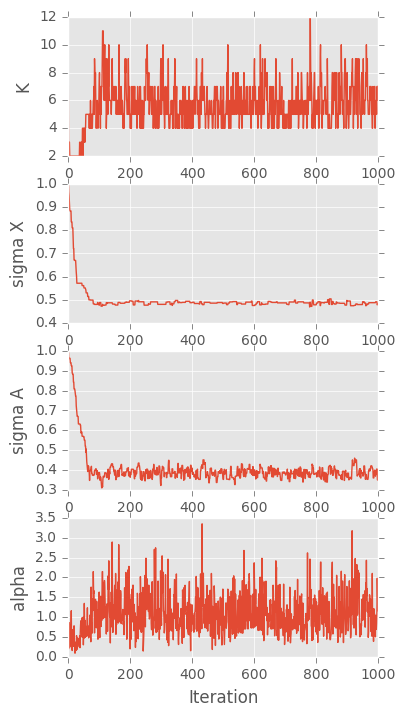

In [17]:
plt.rcdefaults()
plt.style.use('ggplot')

plt.figure(figsize=(4, 8))
plt.subplot(411)
plt.plot(np.arange(len(chain_K)), np.squeeze(chain_K, axis=(1,)))
plt.xlabel('Iteration')
plt.ylabel('K')

plt.subplot(412)
plt.plot(np.arange(len(chain_sigma_X)), np.squeeze(chain_sigma_X, axis=(1,)))
plt.xlabel('Iteration')
plt.ylabel('sigma X')

plt.subplot(413)
plt.plot(np.arange(len(chain_sigma_A)), np.squeeze(chain_sigma_A, axis=(1,)))
plt.xlabel('Iteration')
plt.ylabel('sigma A')

plt.subplot(414)
plt.plot(np.arange(len(chain_alpha)), np.squeeze(chain_alpha, axis=(1,)))
plt.xlabel('Iteration')
plt.ylabel('alpha')
plt.show()

From the trace plots, we see the the various parameters are converging well. $\sigma_X$ converges to its true value 0.5.

### 6.2 Estimating Number of Latent Features

Lets assess a histogram of the posterior for K, which is the number of estimated latent features.

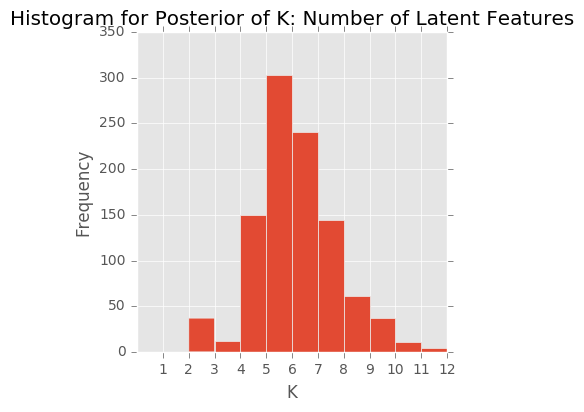

In [23]:
plt.figure(figsize=(4, 4))
plt.hist(np.squeeze(chain_K, axis=(1,)))
plt.xlim(0, max(np.squeeze(chain_K, axis=(1,))))
plt.xticks(range(1,13))
plt.xlabel('K')
plt.ylabel('Frequency')
plt.title('Histogram for Posterior of K: Number of Latent Features')
plt.show()

We see that the mode for the posterior of K (number of latent features) is 6, while the original number of latent features is 4. Lets assess the number of of latent features possessed by each image from the posterior of Z.

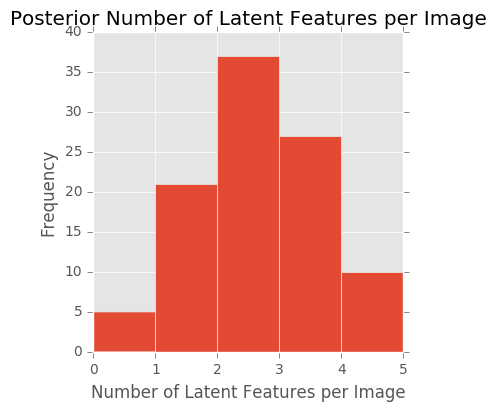

In [19]:
plt.figure(figsize=(4, 4))
final_Z = chain_Z[len(chain_Z)-1,::]
plt.hist(np.sum(final_Z, axis=1,dtype=np.int64), bins=5)
plt.xlabel('Number of Latent Features per Image')
plt.ylabel('Frequency')
plt.title('Posterior Number of Latent Features per Image')
plt.show()

We find that most of the images contain less than 5 features. Therefore we can determine that the true number of latent features is less than 5. The outliers are probably due to noise, and our sampler is correctly identifying the number of latent features. 

### 6.3 Extracting the Latent Features

We can get the posterior expectation of W using the equation given by Griffiths and Ghahramani (Griffiths and Ghahramani, 2005)

$$ E[W \mid Z] = \big( Z^{T} Z +\frac{\sigma_X}{\sigma_A} I \big)^{-1} Z^{T} X$$

Where

$Z$ - Last sampled matrix with the number of columns truncated to K=4

$\sigma_X$ - Posterior mean after burn-in

$\sigma_A$ - Posterior mean after burn-in

In [20]:
burnIn = int(np.round(len(chain_K)*.2))
K_post_choice = 4
final_Z = chain_Z[len(chain_Z)-1,:,0:K_post_choice]
post_sigma_X_mean = np.mean(np.squeeze(chain_sigma_X, axis=(1,))[burnIn:])
post_sigma_A_mean = np.mean(np.squeeze(chain_sigma_A, axis=(1,))[burnIn:])
M_fin = np.linalg.inv(np.dot(final_Z.T, final_Z) + (post_sigma_X_mean**2/post_sigma_A_mean**2) * np.eye(K_post_choice))
post_exp_W  = np.dot(M_fin, np.dot(final_Z.T, image_data))

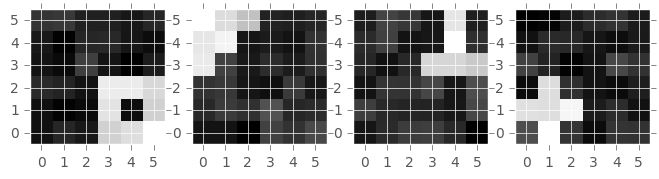

In [21]:
##Latent Features
fig = plt.figure()
a=fig.add_subplot(1,4,1)
plt.imshow(post_exp_W[0,:].reshape(6,6),cmap=plt.get_cmap('gray'), interpolation='nearest',origin='lower')
a=fig.add_subplot(1,4,2)
plt.imshow(post_exp_W[1,:].reshape(6,6),cmap=plt.get_cmap('gray'),  interpolation='nearest',origin='lower')
a=fig.add_subplot(1,4,3)
plt.imshow(post_exp_W[2,:].reshape(6,6),cmap=plt.get_cmap('gray'),  interpolation='nearest',origin='lower')
a=fig.add_subplot(1,4,4)
plt.imshow(post_exp_W[3,:].reshape(6,6),cmap=plt.get_cmap('gray'),  interpolation='nearest',origin='lower')
pass

We see that we were able to extract the original base images (latent features) from the simulated noisy images. The original base images used to simulate the images are show again below.

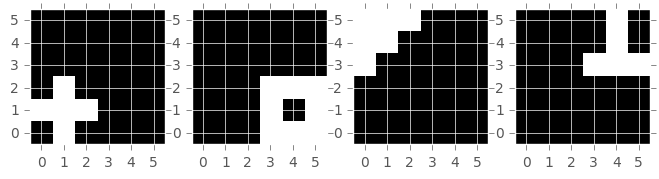

In [22]:
fig = plt.figure()
a=fig.add_subplot(1,4,1)
plt.imshow(np.matrix(W[0]).reshape(6,6),cmap=plt.get_cmap('gray'),  interpolation='nearest',origin='lower')
a=fig.add_subplot(1,4,2)
plt.imshow(np.matrix(W[1]).reshape(6,6),cmap=plt.get_cmap('gray'),  interpolation='nearest',origin='lower')
a=fig.add_subplot(1,4,3)
plt.imshow(np.matrix(W[2]).reshape(6,6),cmap=plt.get_cmap('gray'),  interpolation='nearest',origin='lower')
a=fig.add_subplot(1,4,4)
plt.imshow(np.matrix(W[3]).reshape(6,6),cmap=plt.get_cmap('gray'),  interpolation='nearest',origin='lower')
plt.show()

### 7 Conclusion

In our paper, we discuss the Indian Buffet Process and its application as a prior in Bayesian non-parametric unsupervised learning. We illustrate a simple linear Gaussian model described by Griffiths & Ghahramani (Griffiths & Ghahramani, 2005) and a Markov Chain Monte Carlo (MCMC) sampling algorithim that provides approximate inference for the model. We were able to demonstate the efficacy of the algorithim, by simulating images that contain zero of more latent base images with added noise (images modeled as linear gaussian model). With the MCMC sampler we were able to extract the latent base images from the noisy simulated images. We also optimized the sampler by tweaking the computations, particularly in the likelihood function, which resulted in a faster sampler. 

### 8 References


[1] Thomas Griffiths and Zoubin Ghahramani. Infinite latent feature models and the Indian buffet process. 2005.

[2] Thomas Griffiths and Zoubin Ghahramani. Infinite latent feature models and the Indian buffet process. technical report 2005-     001. 2005

[3] Ilker Yildirim. http://www.mit.edu/ilkery/.

[4] Ilker Yildirim. Bayesian statistics: Indian buffet process. 2012.

[5] Dipesh Gautam. Indian Buffet Process and its application in the Infinite Latent Feature Model. 2015

[6] Christine Chai. Implementation of the Indian Buffet Process. 2015

[7] Radhika Anand. Infinite Latent Feature Models and the Indian Buffet Process. 2015